In [1]:
import warnings
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import numpy as np
from scipy import signal

from timescales.sim import sim_exp_decay, sim_spikes_synaptic
from timescales.fit import ACF, convert_knee_val, fit_psd
from timescales.plts import plot_connected_scatter

from neurodsp.sim import sim_synaptic_kernel, sim_bursty_oscillation
from neurodsp.utils.norm import normalize_sig
from neurodsp.spectral import compute_spectrum

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import yule_walker

### Autoregressive Modeling
This notebooks uses an AR(p) model to fit a 1s signal. PSD may be directly estimated from an AR model's parameters or from a signal that is simulated based on the model's parameters.

#### 1. Simulate

A short signal is simulated with a 20hz knee. Short duration signals produce noisy ACF or PSD, resulting in poor timescale estimates.

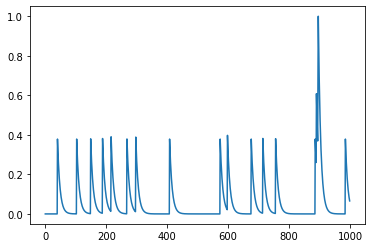

In [2]:
np.random.seed(0)
n_seconds = 1
fs = 1000
knee_freq = 20
tau = convert_knee_val(knee_freq)

sig, _ = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1, mu=50)
freqs_orig, powers_orig = compute_spectrum(sig, fs)

plt.figure(0)
plt.plot(sig)

#### 2. Fit

Fit using a AR(2) process to the signal. From the fit, the PSD is directly estimated. The AR coefficients (phi) are alternatively be estimated using the Yule-Walker method.

Fitting an AR(2) is on the order of micro to milliseconds. This is in contrast to the aABC approachm which is on the order of minutes (Zeraati, 2020).

In [3]:
ar_order = 2

# Esimated phi from AR(p) fit
ar = ARIMA(sig, order=(ar_order, 0, 0)).fit()
phis = ar.params[1:-1]

coeffs = np.append(1, -phis)
freqs, powers = signal.freqz(1, coeffs, fs=fs)
powers = powers.real

# Estimates coefficients (phi) using Yule-Walker
phis_yw, _ = yule_walker(sig, order=ar_order, method='mle')

coeffs = np.append(1, -phis_yw)
freqs_yw, powers_yw = signal.freqz(1, coeffs, fs=fs)
powers_yw = powers_yw.real

Below shows how fitting an AR(2) process de-noises the PSD. The AR(2) PSDs also follow the expected Lorentzian form.

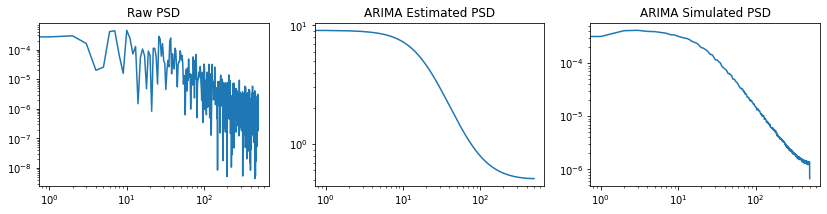

In [4]:
sig_est = ar.simulate(1000000)
freqs_est, powers_est = compute_spectrum(sig_est, fs)
_, kf, _ = fit_psd(freqs_orig, powers_orig, (0, 100))
_, kf_est, _ = fit_psd(freqs_est, powers_est, (0, 100))


fig, axes = plt.subplots(ncols=3, figsize=(14, 3))

axes[0].loglog(freqs_orig, powers_orig)
axes[0].set_title('Raw PSD')

axes[1].loglog(freqs, powers)
axes[1].set_title('ARIMA Estimated PSD')

axes[2].loglog(freqs_est, powers_est)
axes[2].set_title('ARIMA Simulated PSD');

In [5]:
_, kf_orig, _ = fit_psd(freqs_orig, powers_orig, (0, 100), fooof_init={'max_n_peaks':0})
_, kf_ar_est, _ = fit_psd(freqs, powers, (0, 100), fooof_init={'max_n_peaks':0})
_, kf_ar_sim, _ = fit_psd(freqs_est, powers_est, (0, 100), fooof_init={'max_n_peaks':0})

print('Ground Truth: 20 Hz')
print(f'Raw Est.    : {kf} Hz')
print(f'AR Est.     : {kf_ar_est} Hz')
print(f'AR Sim.     : {kf_ar_sim} Hz')

Ground Truth: 20 Hz
Raw Est.    : 9.110168080053581e-09 Hz
AR Est.     : 15.543477802898188 Hz
AR Sim.     : 20.01583827895144 Hz


#### 3. Simulation Distribution

To ensure the above results aren't due to random seeding, below the process is repeated many times to produce a distribution of estimates.

In [6]:
n_seconds = 1
fs = 1000
tau = convert_knee_val(knee_freq)

ar_order = 2
niters = 100

knee_freqs = np.zeros((niters, 2))

for i in tqdm(range(niters)):
    np.random.seed(i)
    
    # Simulate
    sig, _ = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1)
    freqs, powers = compute_spectrum(sig, fs)
    
    # Fit time series AR(2)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        ar = ARIMA(sig, order=(ar_order, 0, 0)).fit()
    phis = ar.params[1:-1]

    # Estimate PSD
    coeffs = np.append(1, -phis)
    freqs_est, powers_est = signal.freqz(1, coeffs, fs=fs)
    powers_est = powers_est.real
    
    # Fit PSD
    _, kf, _ = fit_psd(freqs, powers, (0, 100), fooof_init={'max_n_peaks':0})
    _, kf_est, _ = fit_psd(freqs_est, powers_est, (0, 100), fooof_init={'max_n_peaks':0})
    
    knee_freqs[i] = [kf, kf_est]

  0%|          | 0/100 [00:00<?, ?it/s]

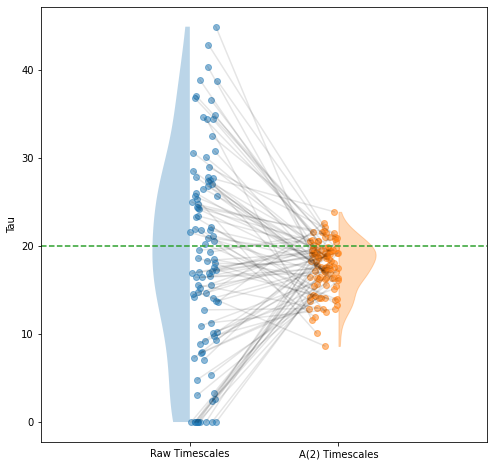

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

plot_connected_scatter(knee_freqs[:, 0], knee_freqs[:, 1], ax=ax, title='',
                       xticklabels=['Raw Timescales', 'A(2) Timescales'])
plt.axhline(20, color='C2', ls='--');

#### 4. Oscillations

One of the claims against AR fitting is the difficulty accounting for other structure sources in the time domain (i.e. oscillations, dynamic timescales, slow drifts, etc).

Below demonstrates that AR fitting reduces noise / smoothes the PSD in the presence of oscillations. The temporal structure of the oscillation can be preserved given a large enough AR order (AR(5)). Spectral parameterization may then remove the oscillitory peaks. However, at lower orders (AR(2)), oscillator components are not presereved in the PSD, but the exponential decay process is.

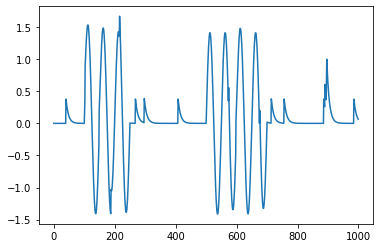

In [8]:
np.random.seed(0)
n_seconds = 1
fs = 1000
knee_freq = 20
tau = convert_knee_val(knee_freq)

sig, _ = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1, mu=50)
osc = sim_bursty_oscillation(n_seconds, fs, 20)

sig += (osc * 1)

freqs_orig, powers_orig = compute_spectrum(sig, fs)

plt.figure(0)
plt.plot(sig);

In [9]:
ar2 = ARIMA(sig, order=(2, 0, 0)).fit()
ar5 = ARIMA(sig, order=(5, 0, 0)).fit()

sig_est = ar.simulate(1000000)
freqs_est, powers_est = compute_spectrum(sig_est, fs)
_, kf_est, _ = fit_psd(freqs_est, powers_est, (0, 100))

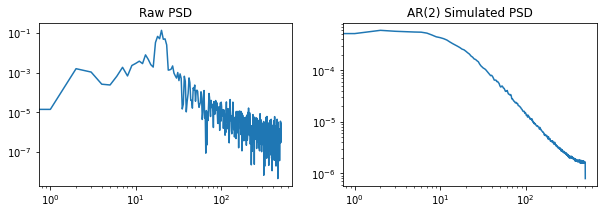

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].loglog(freqs_orig, powers_orig)
axes[0].set_title('Raw PSD')

axes[1].loglog(freqs_est, powers_est)
axes[1].set_title('AR(2) Simulated PSD');

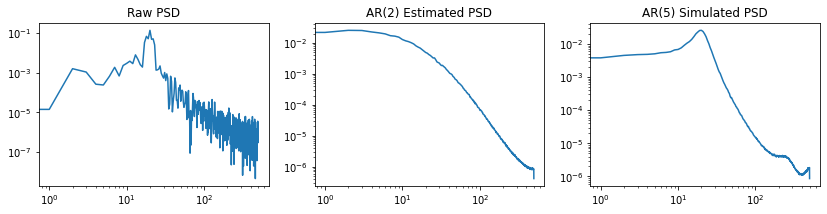

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 3))

sig_est_2 = ar2.simulate(1000000)
sig_est_5 = ar5.simulate(1000000)

freqs_2, powers_2 = compute_spectrum(sig_est_2, fs)
freqs_5, powers_5 = compute_spectrum(sig_est_5, fs)

axes[0].loglog(freqs_orig, powers_orig)
axes[0].set_title('Raw PSD')

axes[1].loglog(freqs_2, powers_2)
axes[1].set_title('AR(2) Estimated PSD')

axes[2].loglog(freqs_5, powers_5)
axes[2].set_title('AR(5) Simulated PSD');

In [12]:
n_seconds = 1
fs = 1000
tau = convert_knee_val(20)

ar_order = 5
niters = 100

knee_freqs = np.zeros((niters, 2))

for i in tqdm(range(niters)):
    np.random.seed(i)
    
    # Simulate
    sig, _ = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1)
    freqs, powers = compute_spectrum(sig, fs)
    
    # Fit time series AR(2)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        ar = ARIMA(sig, order=(ar_order, 0, 0)).fit()
    phis = ar.params[1:-1]

    # Estimate PSD
    coeffs = np.append(1, -phis)
    freqs_est, powers_est = signal.freqz(1, coeffs, fs=fs)
    powers_est = powers_est.real
    
    # Fit PSD
    _, kf, _ = fit_psd(freqs, powers, (0, 100), fooof_init={'max_n_peaks': 1})
    _, kf_est, _ = fit_psd(freqs_est, powers_est, (0, 100), fooof_init={'max_n_peaks':1})
    
    knee_freqs[i] = [kf, kf_est]

  0%|          | 0/100 [00:00<?, ?it/s]

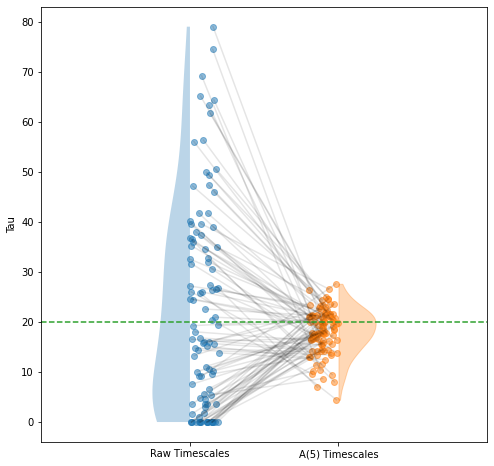

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

plot_connected_scatter(knee_freqs[:, 0], knee_freqs[:, 1], ax=ax, title='',
                       xticklabels=['Raw Timescales', 'A(5) Timescales'])
plt.axhline(20, color='C2', ls='--');